## Frequency 20hz

Siamese Network를 이용하였음.

기존의 multibranch-CNN and BI-LSTM model보다 20hz에서 향상됨을 확인하였음.

문제는 편차가 너무 커서 0.5로는 의미 있는 결과라고 보기 어려움

trash 폴더 까지 갈 정도는 아닌데, 일단 폐기

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
from tensorflow.keras.utils import Sequence

import numpy as np
import time
import numpy as np
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

from data.pamap2.pamap2 import create_pamap2
from other_models.attention.attentive_pooling import AttentionWithContext
from utils import *

# from wandb.keras import WandbCallback

# Random State

In [2]:
secs = time.time()
tm = time.localtime(secs)

time_string = time.strftime('%Y%m%d%I%M%S', tm)
time_int = int(time_string) % (2**32 - 1)
time_string = str(time_int)
print('random_state : ' , time_int)

random_state :  4196985446


# HyperParamters

In [3]:
lr = 0.0001
min_lr = 0.001
batch_size = 400
epoch = 100
monitor = "val_classified_loss"
if monitor == "val_classified_accuracy":
    mode = "max"
else: mode = "min"
loss_alpha = 0.9

cnn_channel1 = 64
cnn_channel2 = 32
dropout_rate = 0.5
lstm_channel1 = 64
lstm_channel2 = 32
dense_channel = 128
contrastive_output = 32

kernel_size1 = 3
kernel_size2 = 7
kernel_size3 = 11

In [4]:
def CNN_Set(input_shape, kernel_size, name="Set"):
    
    inputs = tf.keras.layers.Input(input_shape)
    conv1 = tf.keras.layers.Conv1D(cnn_channel1, kernel_size=kernel_size, activation="relu")
    conv2 = tf.keras.layers.Conv1D(cnn_channel2, kernel_size=kernel_size, activation="relu")
    dropout = tf.keras.layers.Dropout(dropout_rate)
    maxpooling = tf.keras.layers.MaxPool1D(pool_size=2)
    flatten = tf.keras.layers.Flatten()
    
    x = tf.keras.layers.TimeDistributed(conv1)(inputs)
    x = tf.keras.layers.TimeDistributed(conv2)(x)
    x = tf.keras.layers.TimeDistributed(dropout)(x)
    x = tf.keras.layers.TimeDistributed(maxpooling)(x)
    x = tf.keras.layers.TimeDistributed(flatten)(x)
    
    model = tf.keras.models.Model(inputs, x, name=name)
    return model

def Encoder(input_shape, name="encoder"):
    
    inputs = tf.keras.layers.Input(input_shape)
    branch_1 = CNN_Set(input_shape, kernel_size=kernel_size1, name="branch_1")
    branch_2 = CNN_Set(input_shape, kernel_size=kernel_size2, name="branch_2")
    branch_3 = CNN_Set(input_shape, kernel_size=kernel_size3, name="branch_3")

    one = branch_1(inputs)
    two = branch_2(inputs)
    three = branch_3(inputs)
    concat = tf.keras.layers.Concatenate()([one, two, three])
    
    model = tf.keras.models.Model(inputs, concat, name=name)
    return model

def Balancing_Contrastive(input_shape, contrastive_outputs, n_outputs):
    inputs = tf.keras.layers.Input(input_shape)
    
    encoded = Encoder(input_shape)(inputs)
    ### classifier
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_channel1, return_sequences=True))(encoded)
    x =  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_channel2, return_sequences=False))(x)
    x = tf.keras.layers.Dense(dense_channel)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    classified = tf.keras.layers.Dense(n_outputs, activation="softmax", name="classified")(x)
    
    ### contrastive
    x = tf.keras.layers.GlobalAveragePooling1D()(encoded)
    x = tf.keras.layers.LayerNormalization()(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    contrastive = tf.keras.layers.Dense(contrastive_outputs, activation="relu", name="contrastive")(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=[classified, contrastive], name="Balancing")     
    return model

In [5]:
def plot_training_loss(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

def plot_training_acc(H, plotPath):
    	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["classified_accuracy"], label="train_accuracy")
	plt.plot(H.history["val_classified_accuracy"], label="val_accuracy")
	plt.title("Training accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("accuracy")
	plt.legend(loc="lower left")
	if plotPath is not None:
		plt.savefig(plotPath)
	else:
		plt.show()

In [6]:
def create_dataset(name, data="frequency_100"):
    print("creating dataset")
    if name == "pamap2":
        x_train, y_train = create_pamap2(data=data)
        x_train = x_train.reshape(-1, 4, 25, 18)

    if data == "frequency_100":
        # # 80%, 10%, 10% respectively in train, val, test dataset
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=time_int, stratify=y_train)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
        print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
        print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
        print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)
        
        return x_train, y_train, x_val, y_val, x_test, y_test
    elif data == "frequency_20":
        # 80%, 10%, 10% respectively in train, val, test dataset
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.4, random_state=time_int, stratify=y_train)
        x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=time_int, stratify=y_test)
        print("x_train.shape : ", x_train.shape, "y_train.shape: ", y_train.shape)
        print("x_val.shape   : ", x_val.shape,    "y_val.shape: ", y_val.shape)
        print("x_test.shape  : ", x_test.shape,   "y_test.shape: ", y_test.shape)

        return x_train, y_train, x_val, y_val, x_test, y_test
        
if __name__ == "__main__":
    # 데이터셋 & classifier
    dataset_name = "pamap2"      # wisdm / paamp2 / skoda

    # frequency_100_x_train, frequency_100_y_train = create_dataset(name=dataset_name, data="frequency_100")
    frequency_20_x_train, frequency_20_y_train, frequency_20_x_val, frequency_20_y_val, frequency_20_x_test, frequency_20_y_test = create_dataset(name=dataset_name, data="frequency_20")

creating dataset
c:\Users\hosoo\Desktop\har2\contrastive_frequency
x_train.shape :  (4582, 4, 25, 18) y_train.shape:  (4582, 12)
x_val.shape   :  (1528, 4, 25, 18) y_val.shape:  (1528, 12)
x_test.shape  :  (1528, 4, 25, 18) y_test.shape:  (1528, 12)


In [7]:
class SupervisedContrastiveLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super(SupervisedContrastiveLoss, self).__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # print("type : " , type(labels))
        # labels = tf.math.argmax(labels, axis=1).reshape(-1, 1)
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)

In [8]:
contrastive_y_train = np.argmax(frequency_20_y_train, axis=1).reshape(-1, 1)
contrastive_y_val = np.argmax(frequency_20_y_val, axis=1).reshape(-1, 1)
contrastive_y_test = np.argmax(frequency_20_y_test, axis=1).reshape(-1, 1)
print("contrastive_y_train shape : ", contrastive_y_train.shape)
print("contrastive_y_val shape : ", contrastive_y_val.shape)
print("contrastive_y_test shape : ", contrastive_y_test.shape)

contrastive_y_train shape :  (4582, 1)
contrastive_y_val shape :  (1528, 1)
contrastive_y_test shape :  (1528, 1)


In [9]:
filepath = "result/frequency_" + dataset_name + "_" + time_string + ".h5"
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=5, min_lr=min_lr)
checkpoint = ModelCheckpoint(filepath, verbose = 0, monitor=monitor, mode=mode, save_best_only=True, save_weights_only = True)

print("[Prtraninig Encoder with Supervised Contrastive Loss]")
model = Balancing_Contrastive(frequency_20_x_train.shape[1:], contrastive_output, frequency_20_y_train.shape[1])
model.summary()

[Prtraninig Encoder with Supervised Contrastive Loss]
Model: "Balancing"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 25, 18)]  0                                            
__________________________________________________________________________________________________
encoder (Functional)            (None, 4, 576)       67488       input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 4, 128)       328192      encoder[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 64)           41216       bidirectional[0][0]              
____________________________________

In [10]:
model.compile(loss=["categorical_crossentropy", SupervisedContrastiveLoss(temperature=1)], loss_weights=[loss_alpha, 1-loss_alpha], 
              optimizer=tf.keras.optimizers.Adam(learning_rate=lr), metrics=["accuracy"])
history = model.fit(frequency_20_x_train, [frequency_20_y_train, contrastive_y_train], 
                    validation_data=(frequency_20_x_val, [frequency_20_y_val, contrastive_y_val]),
                    batch_size=batch_size, epochs=epoch, verbose=1, callbacks=[reduce_lr, checkpoint])
print("[Finished Prtraining]")

Epoch 1/100
12/12 [==============================] - 8s 139ms/step - loss: 2.8232 - classified_loss: 2.4877 - contrastive_loss: 5.8430 - classified_accuracy: 0.2259 - contrastive_accuracy: 0.0369 - val_loss: 2.7321 - val_classified_loss: 2.3910 - val_contrastive_loss: 5.8015 - val_classified_accuracy: 0.2435 - val_contrastive_accuracy: 0.0425
Epoch 2/100
12/12 [==============================] - 0s 32ms/step - loss: 2.0108 - classified_loss: 1.5872 - contrastive_loss: 5.8235 - classified_accuracy: 0.4841 - contrastive_accuracy: 0.0295 - val_loss: 2.6576 - val_classified_loss: 2.3112 - val_contrastive_loss: 5.7756 - val_classified_accuracy: 0.4038 - val_contrastive_accuracy: 0.0360
Epoch 3/100
12/12 [==============================] - 0s 30ms/step - loss: 1.6724 - classified_loss: 1.2140 - contrastive_loss: 5.7975 - classified_accuracy: 0.6213 - contrastive_accuracy: 0.0262 - val_loss: 2.6033 - val_classified_loss: 2.2537 - val_contrastive_loss: 5.7495 - val_classified_accuracy: 0.4758 - 

Random State :  4196985446


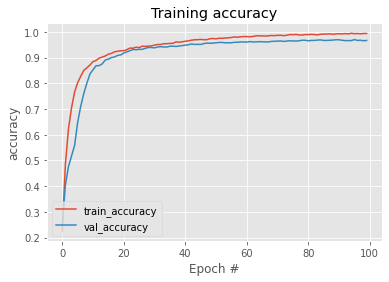

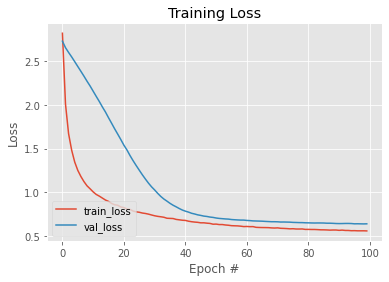

48/48 [==============================] - 1s 12ms/step - loss: 0.4230 - classified_loss: 0.1624 - contrastive_loss: 2.7688 - classified_accuracy: 0.9542 - contrastive_accuracy: 6.5445e-04
test acc  :  0.9541884660720825
test loss :  0.4230138659477234
f1 score  :  0.9534200220924158
[[141   1   6   0   0   0   0   0   1   1   2   0]
 [  0 141   2   0   0   0   0   0   1   1   1   0]
 [  0   0 147   0   0   0   0   0   0   1   1   0]
 [  0   0   1 185   0   0   0   1   2   0   0   0]
 [  0   0   1   1  73   0   0   0   1   1   0   0]
 [  0   0   1   0   0 127   0   0   0   0   2   0]
 [  0   1   2   0   0   0 141   0   0   0   4   0]
 [  0   0   3   1   0   0   0  87   0   0   0   0]
 [  0   0   5   0   0   0   0   2  73   0   1   0]
 [  0   0   1   0   0   2   0   0   0 124  11   0]
 [  0   0   3   0   0   1   0   0   0   0 185   0]
 [  0   1   1   0   0   0   0   1   0   0   1  34]]


<Figure size 432x288 with 0 Axes>

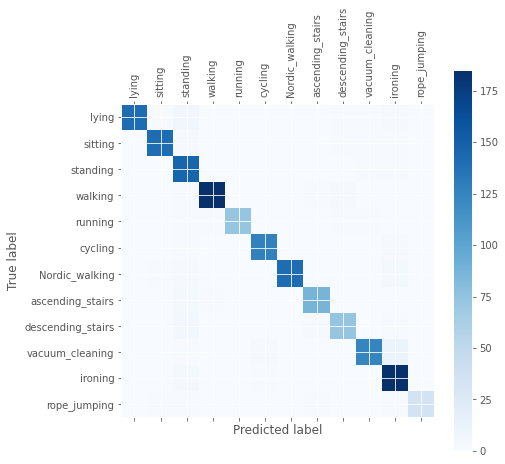

In [11]:
def print_test_result(model, filepath, x_test, y_classified, y_contrastive, dataset="wisdm"):
    model.load_weights(filepath)
    test_results = model.evaluate([x_test], [y_classified, y_contrastive])
    y_pred = model.predict([x_test])[0]
    matrix = confusion_matrix(y_classified.argmax(axis=1), y_pred.argmax(axis=1))

    print("test acc  : ", test_results[3])
    print("test loss : ", test_results[0])

    score = f1_score(y_classified.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
    print("f1 score  : ", score)

    print(matrix)
    fontdict={'fontsize': 12}
    if dataset == "wisdm":
        label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
    elif dataset == "pamap2":
        label = ['lying', 'sitting', 'standing', 'walking', 'running', 'cycling', 'Nordic_walking', 'ascending_stairs', 'descending_stairs', 'vacuum_cleaning', 'ironing', 'rope_jumping']
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, interpolation="nearest", cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(label)))
    ax.set_xticklabels(label)
    ax.set_yticks(np.arange(len(label)))
    ax.set_yticklabels(label)
    plt.xticks(rotation = 90)
    
    ax.set_xlabel("Predicted label", **fontdict)
    ax.set_ylabel("True label", **fontdict)
    
    plt.show()

print("Random State : ", time_string)
plot_training_acc(history, None)
plot_training_loss(history, None)
plt.clf()
print_test_result(model, filepath, frequency_20_x_test, frequency_20_y_test, contrastive_y_test, dataset=dataset_name)